In [2]:
# imports
from transformers import DistilBertTokenizer, TFDistilBertModel
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import pdfplumber
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from prettytable import PrettyTable

In [2]:
# set random seeds
seed = 7
tf.random.set_seed(seed)
random.seed(seed)

In [3]:
BATCH_SIZE = 4

# Feed Forward Neural Network with BoW features

In [5]:
# load all the data
with open('X_train_bow.npy', 'rb') as f:
    X_train = np.load(f, allow_pickle=True)
with open('X_test_bow.npy', 'rb') as f:
    X_test = np.load(f, allow_pickle=True)
with open('y_train_bow.npy', 'rb') as f:
    y_train = np.load(f, allow_pickle=True)
with open('y_test_bow.npy', 'rb') as f:
    y_test = np.load(f, allow_pickle=True)

In [6]:
# create train and cv data
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=.15, random_state=13)

In [7]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(53, 100)
(10, 100)
(27, 100)


In [8]:
# mean centering, variance scaling
scaler = StandardScaler()
# getting mean and variance
scaler.fit(X_train)
# standardizing train data
X_train = scaler.transform(X_train)
# standardizing cv data
X_cv = scaler.transform(X_cv)
# standardizing test data
X_test = scaler.transform(X_test)

In [11]:
# create input-output pair and batch the data.
X_train_data = tf.data.Dataset \
                .from_tensor_slices((X_train, y_train)) \
                .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
X_cv_data = tf.data.Dataset \
                .from_tensor_slices((X_cv, y_cv)) \
                .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
X_test_data = tf.data.Dataset \
                .from_tensor_slices((X_test, y_test)) \
                .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
# create simple FFNN with TF2 functional API
inp = layers.Input(shape=(100,))
x = layers.Dense(64, activation='relu')(inp)
x = layers.Dense(8, activation='relu')(x)
out = layers.Dense(1, activation='relu')(x)
model = keras.Model(inputs=inp, outputs=out, name='Bow_Regression')

In [13]:
model.summary()

Model: "Bow_Regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 6,993
Trainable params: 6,993
Non-trainable params: 0
_________________________________________________________________


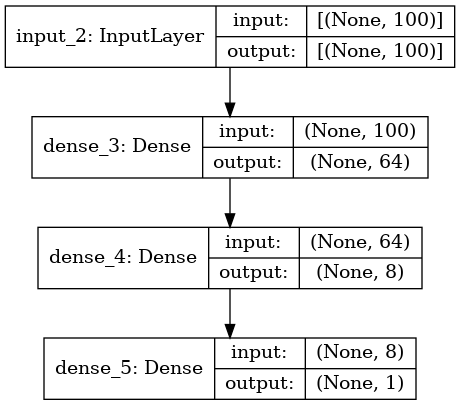

In [14]:
keras.utils.plot_model(model, "Bow_Regression.png", show_shapes=True)

In [15]:
# callback to stop execution early if the module is not improving much.
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# compile the model with adam optemizer
model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=1e-6), loss='mse', metrics=['mae'])

# train the model
history = model.fit(
    X_train_data,
    validation_data=X_cv_data,
    epochs=20,callbacks=[early_stopping]
)

Epoch 1/20


2022-02-08 07:12:02.117258: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


14/14 [==============================] - 1s 7ms/step - loss: 1904.9497 - mae: 40.7673 - val_loss: 1219.9224 - val_mae: 30.2563
Epoch 2/20
14/14 [==============================] - 0s 2ms/step - loss: 1904.9148 - mae: 40.7669 - val_loss: 1219.9124 - val_mae: 30.2561
Epoch 3/20
14/14 [==============================] - 0s 2ms/step - loss: 1904.8838 - mae: 40.7665 - val_loss: 1219.9023 - val_mae: 30.2559
Epoch 4/20
14/14 [==============================] - 0s 2ms/step - loss: 1904.8531 - mae: 40.7661 - val_loss: 1219.8923 - val_mae: 30.2556
Epoch 5/20
14/14 [==============================] - 0s 2ms/step - loss: 1904.8224 - mae: 40.7657 - val_loss: 1219.8826 - val_mae: 30.2554
Epoch 6/20
14/14 [==============================] - 0s 2ms/step - loss: 1904.7919 - mae: 40.7654 - val_loss: 1219.8727 - val_mae: 30.2552
Epoch 7/20
14/14 [==============================] - 0s 2ms/step - loss: 1904.7614 - mae: 40.7650 - val_loss: 1219.8627 - val_mae: 30.2550
Epoch 8/20
14/14 [===========================

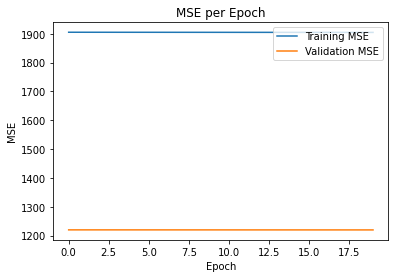

In [19]:
# show loss curve
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training MSE')
plt.plot(val_loss, label='Validation MSE')
plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('MSE per Epoch')
plt.show()

In [16]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 68ms/step - loss: 1800.1959 - mae: 39.5751


[1800.1959228515625, 39.57508850097656]

In [17]:
model.evaluate(X_cv, y_cv)

1/1 [==============================] - 0s 13ms/step - loss: 1219.7332 - mae: 30.2521


[1219.733154296875, 30.252111434936523]

In [18]:
model.evaluate(X_train, y_train)

2/2 [==============================] - 0s 2ms/step - loss: 1904.3433 - mae: 40.7598


[1904.34326171875, 40.759830474853516]

**SUMMARY**
* We have a total of 90 data points.
* We have 100 features.
* We have 53 data points for training.
* We have 10 data points for cross validation.
* We have 27 data points for testing.
* Model has a total of 6993 trainable parameters. And all three activation functions have ReLU activation function.
* Train mse (mean squared error) is 1904.343
* Train mae (mean absolute error) is 40.7598
* CV mse (mean squared error) is 1219.7331
* CV mae (mean absolute error) is 30.2521
* Test mse (mean squared error) is 1800.1959
* Test mae (mean absolute error) is 39.575

# Feed Forward Neural Network with BoW and Average W2V features

In [82]:
# load all the data
with open('X_train_bow.npy', 'rb') as f1, open('X_train_w2v.npy', 'rb') as f2:
    X_train = np.concatenate((np.load(f1, allow_pickle=True), np.load(f2, allow_pickle=True)), axis=1)
with open('X_test_bow.npy', 'rb') as f1, open('X_test_w2v.npy', 'rb') as f2:
    X_test = np.concatenate((np.load(f1, allow_pickle=True), np.load(f2, allow_pickle=True)), axis=1)
with open('y_train_bow.npy', 'rb') as f:
    y_train = np.load(f, allow_pickle=True)
with open('y_test_bow.npy', 'rb') as f:
    y_test = np.load(f, allow_pickle=True)

In [83]:
# create train and cv data
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=.15, random_state=13)

In [84]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(53, 300)
(10, 300)
(27, 300)


In [85]:
# create input-output pair and batch the data.
X_train_data = tf.data.Dataset \
                .from_tensor_slices((X_train, y_train)) \
                .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
X_cv_data = tf.data.Dataset \
                .from_tensor_slices((X_cv, y_cv)) \
                .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
X_test_data = tf.data.Dataset \
                .from_tensor_slices((X_test, y_test)) \
                .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [86]:
# create simple FFNN with TF2 functional API
inp = layers.Input(shape=(300,))
x = layers.Dense(128, activation='relu')(inp)
x = layers.Dense(16, activation='relu')(x)
out = layers.Dense(1, activation='relu')(x)
model = keras.Model(inputs=inp, outputs=out, name='Bow_avgW2V_Regression')

In [87]:
model.summary()

Model: "Bow_avgW2V_Regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_19 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 17        
Total params: 40,609
Trainable params: 40,609
Non-trainable params: 0
_________________________________________________________________


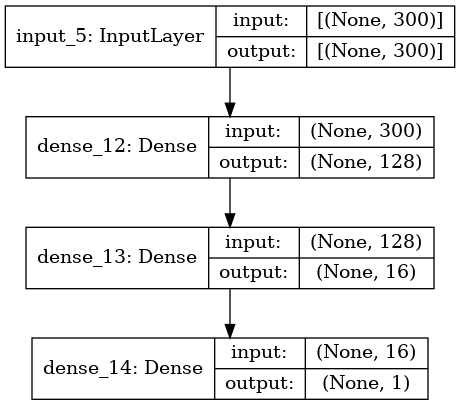

In [66]:
keras.utils.plot_model(model, "Bow_avgW2V_Regression.png", show_shapes=True)

In [67]:
# callback to stop execution early if the module is not improving much.
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# compile the model with adam optemizer
model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=1e-3), loss='mse', metrics=['mae'])

# training the model
history = model.fit(
    X_train_data,
    validation_data=X_cv_data,
    epochs=100,callbacks=[early_stopping]
)

Epoch 1/100
14/14 [==============================] - 0s 6ms/step - loss: 1695.4517 - mae: 38.0242 - val_loss: 849.8220 - val_mae: 23.7552
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 1074.1898 - mae: 29.8778 - val_loss: 435.4951 - val_mae: 17.9977
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 421.9057 - mae: 18.7351 - val_loss: 243.3791 - val_mae: 13.5164
Epoch 4/100
14/14 [==============================] - 0s 2ms/step - loss: 165.4863 - mae: 9.6780 - val_loss: 304.6954 - val_mae: 13.7507
Epoch 5/100
14/14 [==============================] - 0s 2ms/step - loss: 119.0621 - mae: 7.7854 - val_loss: 200.0704 - val_mae: 11.7010
Epoch 6/100
14/14 [==============================] - 0s 2ms/step - loss: 89.8057 - mae: 7.2253 - val_loss: 165.5067 - val_mae: 10.8711
Epoch 7/100
14/14 [==============================] - 0s 2ms/step - loss: 67.3925 - mae: 6.1872 - val_loss: 146.5085 - val_mae: 10.3437
Epoch 8/100
14/14 [==========================

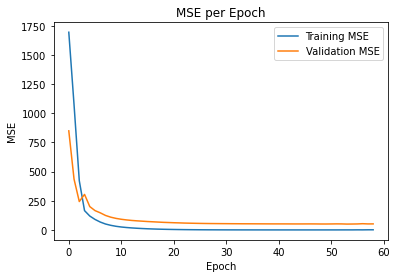

In [68]:
# show loss curve
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training MSE')
plt.plot(val_loss, label='Validation MSE')
plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('MSE per Epoch')
plt.show()

In [69]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 63ms/step - loss: 36.6962 - mae: 4.9607


[36.69621658325195, 4.960657119750977]

In [70]:
model.evaluate(X_cv, y_cv)

1/1 [==============================] - 0s 13ms/step - loss: 50.0981 - mae: 5.2794


[50.098148345947266, 5.279421329498291]

In [71]:
model.evaluate(X_train, y_train)

2/2 [==============================] - 0s 2ms/step - loss: 0.1492 - mae: 0.3321


[0.14919373393058777, 0.33213144540786743]

In [88]:
# compile and train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=1e-3), loss='mse', metrics=['mae'])
history = model.fit(
    X_train_data,
    validation_data=X_cv_data,
    epochs=20,callbacks=[early_stopping]
)

Epoch 1/20
14/14 [==============================] - 0s 6ms/step - loss: 1650.9510 - mae: 37.4818 - val_loss: 756.9403 - val_mae: 22.2069
Epoch 2/20
14/14 [==============================] - 0s 2ms/step - loss: 881.5822 - mae: 27.1498 - val_loss: 290.0041 - val_mae: 16.0316
Epoch 3/20
14/14 [==============================] - 0s 2ms/step - loss: 246.1642 - mae: 13.2173 - val_loss: 339.6078 - val_mae: 15.0371
Epoch 4/20
14/14 [==============================] - 0s 2ms/step - loss: 151.8366 - mae: 8.5877 - val_loss: 251.8313 - val_mae: 13.4431
Epoch 5/20
14/14 [==============================] - 0s 3ms/step - loss: 94.8450 - mae: 7.2204 - val_loss: 175.7615 - val_mae: 11.3434
Epoch 6/20
14/14 [==============================] - 0s 2ms/step - loss: 72.2408 - mae: 6.6280 - val_loss: 160.2516 - val_mae: 11.2593
Epoch 7/20
14/14 [==============================] - 0s 2ms/step - loss: 51.3236 - mae: 5.1850 - val_loss: 139.6668 - val_mae: 10.6902
Epoch 8/20
14/14 [==============================] - 0s

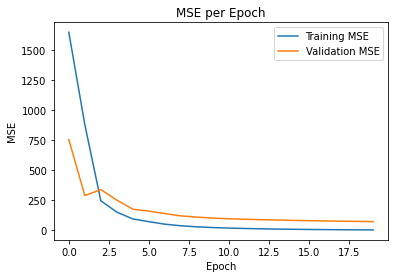

In [89]:
# show loss curve
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training MSE')
plt.plot(val_loss, label='Validation MSE')
plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('MSE per Epoch')
plt.show()

In [90]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 62ms/step - loss: 39.6974 - mae: 5.3252


[39.697391510009766, 5.325167179107666]

In [91]:
model.evaluate(X_cv, y_cv)

1/1 [==============================] - 0s 12ms/step - loss: 72.9421 - mae: 7.0519


[72.94209289550781, 7.0518646240234375]

In [92]:
model.evaluate(X_train, y_train)

2/2 [==============================] - 0s 2ms/step - loss: 3.0928 - mae: 1.3764


[3.0927910804748535, 1.376383900642395]

In [93]:
model.save('bow_avgw2v.h5')

**SUMMARY**
* We have a total of 90 data points.
* We have 300 features.
* We have 53 data points for training.
* We have 10 data points for cross validation.
* We have 27 data points for testing.
* Model has a total of 40,609 trainable parameters. And all three layers have ReLU activation functions as before.
* Train mse (mean squared error) is 3.0928
* Train mae (mean absolute error) is 1.3764
* CV mse (mean squared error) is 72.9421
* CV mae (mean absolute error) is 7.0519
* Test mse (mean squared error) is 39.6974
* Test mae (mean absolute error) is 5.3252
* As we can see this model is very comparable to the stacking ensemble model.

# BERT with Feed Forward Neural Network

In [21]:
# load pretrained models
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [22]:
def pdf2Text(filename):
    ''' load pdf and return the text'''
    text = ''
    # open the pdf file
    with pdfplumber.open(filename) as pdfObj:
        # loop over each page
        for page in pdfObj.pages:
            # get text from the page and concat
            text += page.extract_text()
    # return all texts
    return text

In [23]:
jd = pdf2Text('dataset/Job description.pdf')

In [24]:
# encode with the tokenizer
jd_encoded = tokenizer.encode(jd, max_length=300, padding='max_length', truncation=True)

In [25]:
csvData = pd.read_csv('dataset/data.csv')

In [26]:
# preprocess all resumes
resumes = []
for candidateID in csvData.CandidateID.values:
    # load resume pdf
    resume = pdf2Text('dataset/resumes/'+candidateID+'.pdf')
    resumes.append(resume)

In [27]:
resumes_encoded = []
for resume in resumes:
    # encode with the tokenizer
    resume_encoded = tokenizer.encode(resume, max_length=300, padding='max_length', truncation=True)
    resumes_encoded.append(resume_encoded)
resumes_encoded = np.array(resumes_encoded)

In [28]:
# get output corresponding to CLS token
jd_cls = distilbert_model(np.array([jd_encoded])).last_hidden_state[0][0]

In [29]:
X_data = []
for resume_encoded in resumes_encoded:
    # get output corresponding to CLS token
    resume_cls = distilbert_model(np.array([resume_encoded])).last_hidden_state[0][0]
    X_data.append(tf.concat(axis=0, values = [jd_cls, resume_cls]))
X_data = np.array(X_data)

In [30]:
X_data.shape

(90, 1536)

In [31]:
y = csvData['Match Percentage'].to_numpy()

In [32]:
# create x y pair
X_data_tf = tf.data.Dataset \
                .from_tensor_slices((X_data, y)) \
                .shuffle(100)

In [34]:
train_size = int(.7 * len(X_data_tf))
val_size = int(.1 * len(X_data_tf))

# get train, cv and test data
train_ds = X_data_tf.take(train_size)    
val_ds = X_data_tf.skip(train_size).take(val_size)
test_ds = X_data_tf.skip(train_size).skip(val_size)

In [45]:
print(np.floor(train_size))
print(np.floor(val_size))
print(len(X_data_tf)-np.floor(train_size)-np.floor(val_size))

62.0
9.0
19.0


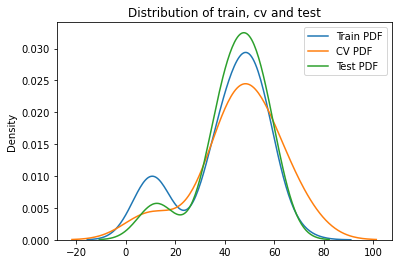

In [35]:
plt.title('Distribution of train, cv and test')
sns.kdeplot([y.numpy() for x, y in train_ds], label='Train PDF')
sns.kdeplot([y.numpy() for x, y in val_ds], label='CV PDF')
sns.kdeplot([y.numpy() for x, y in test_ds], label='Test PDF')
plt.legend()
plt.show()

In [36]:
# batching all the data
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [37]:
# create a FFNN model for BERT outputs
inp = tf.keras.layers.Input(shape=(1536,))
x = tf.keras.layers.Dense(128, activation='relu')(inp)
x = tf.keras.layers.Dense(16, activation='relu')(x)
out = tf.keras.layers.Dense(1, activation='relu')(x)

model = tf.keras.Model(inputs=inp, outputs=out, name='DistilBERT_cls_Regression')

In [38]:
model.summary()

Model: "DistilBERT_cls_Regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1536)]            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               196736    
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 198,817
Trainable params: 198,817
Non-trainable params: 0
_________________________________________________________________


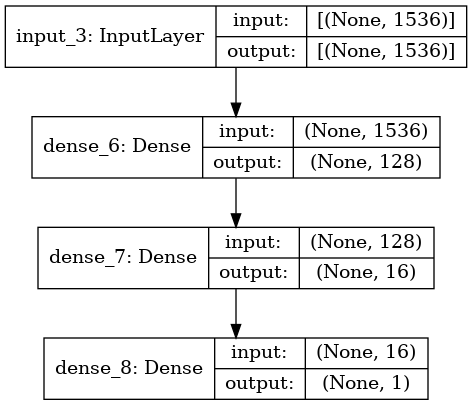

In [39]:
tf.keras.utils.plot_model(model, "DistilBERT_cls_Regression.png", show_shapes=True)

In [40]:
# adam optimiser and mse loss are set
model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=1e-7), loss='mse', metrics=['mae'])

In [41]:
# callback for early stoping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [42]:
# train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,callbacks=[early_stopping]
)

Epoch 1/30
16/16 [==============================] - 0s 5ms/step - loss: 1811.9198 - mae: 39.4611 - val_loss: 2059.8208 - val_mae: 43.2778
Epoch 2/30
16/16 [==============================] - 0s 2ms/step - loss: 1752.7144 - mae: 38.4624 - val_loss: 1543.5151 - val_mae: 34.9800
Epoch 3/30
16/16 [==============================] - 0s 2ms/step - loss: 1906.0579 - mae: 40.5131 - val_loss: 2115.6121 - val_mae: 45.5433
Epoch 4/30
16/16 [==============================] - 0s 2ms/step - loss: 1944.0278 - mae: 41.4576 - val_loss: 1834.6284 - val_mae: 40.4633
Epoch 5/30
16/16 [==============================] - 0s 2ms/step - loss: 1767.6901 - mae: 38.7108 - val_loss: 1890.9420 - val_mae: 40.3011
Epoch 6/30
16/16 [==============================] - 0s 2ms/step - loss: 1786.9291 - mae: 38.6239 - val_loss: 1756.2483 - val_mae: 38.3900
Epoch 7/30
16/16 [==============================] - 0s 2ms/step - loss: 1761.8230 - mae: 38.6524 - val_loss: 1725.7494 - val_mae: 37.6100


In [47]:
# evaluate the model
model.evaluate(test_ds)

5/5 [==============================] - 0s 1ms/step - loss: 1803.7161 - mae: 37.4089


[1803.716064453125, 37.4089469909668]

In [48]:
model.evaluate(val_ds)

3/3 [==============================] - 0s 1ms/step - loss: 1070.5638 - mae: 27.6278


[1070.5638427734375, 27.627777099609375]

In [49]:
model.evaluate(train_ds)

16/16 [==============================] - 0s 846us/step - loss: 1780.1329 - mae: 38.9871


[1780.1329345703125, 38.987091064453125]

**SUMMARY**
* We have a total of 90 data points.
* We have 1536 features. (768+768)
* We have 62 data points for training.
* We have 9 data points for cross validation.
* We have 19 data points for testing.
* The total trainable params are 198,817.
* Train mse (mean squared error) is 1780.1329
* Train mae (mean absolute error) is 38.9871
* CV mse (mean squared error) is 1070.5638
* CV mae (mean absolute error) is 27.6278
* Test mse (mean squared error) is 1803.7161
* Test mae (mean absolute error) is 37.4089

# Performances

In [95]:
performanceTable = PrettyTable(["Model", "Train MSE", "Train MAE", "CV MSE", "CV MAE", "Test MSE", "Test MAE"], align='l')
performanceTable.add_row(["MLP for BoW","1904.343", "40.7598", "1219.7331", "30.2521", "1800.1959", "39.575"])
performanceTable.add_row(["MLP for BoW and Average W2V","3.0928", "1.3764", "72.9421", "7.0519", "39.6974", "5.3252"])
performanceTable.add_row(["MLP for BERT","1780.1329", "38.9871", "1070.5638", "27.6278", "1803.7161", "37.4089"])
print(performanceTable)

+-----------------------------+-----------+-----------+-----------+---------+-----------+----------+
| Model                       | Train MSE | Train MAE | CV MSE    | CV MAE  | Test MSE  | Test MAE |
+-----------------------------+-----------+-----------+-----------+---------+-----------+----------+
| MLP for BoW                 | 1904.343  | 40.7598   | 1219.7331 | 30.2521 | 1800.1959 | 39.575   |
| MLP for BoW and Average W2V | 3.0928    | 1.3764    | 72.9421   | 7.0519  | 39.6974   | 5.3252   |
| MLP for BERT                | 1780.1329 | 38.9871   | 1070.5638 | 27.6278 | 1803.7161 | 37.4089  |
+-----------------------------+-----------+-----------+-----------+---------+-----------+----------+


The Feed Forward Neural Network with BoW and Average W2V features model is performing the best but still not as good as the stacking ensemble model. 
